# Source loading
### PDF loader, splitting, and cleaning

1.  List the directory

In [16]:
from langchain.document_loaders import PyPDFLoader, Docx2txtLoader, PyMuPDFLoader, TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from pprint import pprint
import re
import os

os.chdir('F:\python_stuff\LangChain')
directory = 'ignore/documents/'
extension_type = 'all'

if extension_type == 'all':
    directory_files = [file for file in os.listdir(directory)]
else:
    directory_files = [ file for file in os.listdir(directory) if file.endswith(f'.{extension_type}')]
    
for index, file in enumerate(directory_files):
    print((index, file))

(0, 'An Introduction to Statistical Learning with Applications in R.pdf')
(1, 'ISYE 6501 Lecture Transcripts (2).pdf')
(2, 'Practical_Statistics_for_Data_Science__1663052800.pdf')
(3, 'Supplementary Material – Machine Learning.docx')
(4, 'SystemsDesign_bytebytego.pdf')
(5, 'SystemsDesign_bytebytego_raw.txt')


2. Input key variables for cleaning

In [19]:
# Input key variables for loading, splitting and cleaning
chosen_indices = [3]
split_by_token = True
chunk_size=10000
chunk_overlap=100
remove_pages = False # This is actually removing document chunks, not always pages
front_pages_to_remove = 0
last_pages_to_remove = 0
remove_leftover_delimiters = True
delimiters_to_remove = ['\t', '\n\n', '\n', '   ', '  ']

document_chunks_all = []

splitter = RecursiveCharacterTextSplitter(
            chunk_size=chunk_size,
            chunk_overlap=chunk_overlap,
            separators = ["\n\n", "\n", " ", ""]
            )

token_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=chunk_size, 
    chunk_overlap=chunk_overlap
)


3. Extraction

In [20]:
for chosen_index in chosen_indices:
    document_name = directory_files[chosen_index].split('.')[0]
    file_type = directory_files[chosen_index].split('.')[-1]
    filepath = directory+directory_files[chosen_index]
    print(f'Document to extract: {document_name}')

    #Load the document by calling loader.load()
    if file_type == 'pdf':
        # loader = PyPDFLoader(filepath)
        loader = PyMuPDFLoader(filepath) # This extracts and splits automatically by page, capturing all the metadata
    elif file_type == 'docx':
        loader = Docx2txtLoader(filepath)
    elif file_type == 'txt':
        loader = TextLoader(filepath, autodetect_encoding=True)

    if split_by_token:
        document_chunks = token_splitter.split_documents(loader.load())
    else:
        document_chunks = loader.load_and_split(splitter)
    print(f'Number of chunks extracted: {len(document_chunks)}')

    # Remove pages
    if remove_pages:
        for page_number in range(front_pages_to_remove):
            del document_chunks[0]
        for page_number in range(last_pages_to_remove):
            document_chunks.pop()
        print(f'Number of pages after cleaning: {len(document_chunks)}')

    # Remove all left over the delimiters and extra spaces
    if remove_leftover_delimiters:
        for chunk in document_chunks:
            for delimiter in delimiters_to_remove:
                chunk.page_content = re.sub(delimiter, ' ', chunk.page_content)

    print(f'Example of Metadata: {document_chunks[0].metadata}')
    pprint(document_chunks[0].page_content)
    
    document_chunks_all.extend(document_chunks)
    print(f'\nCurrent length of all document chunks: {len(document_chunks_all)}\n')

Document to extract: Supplementary Material – Machine Learning
Number of chunks extracted: 17
Example of Metadata: {'source': 'ignore/documents/Supplementary Material – Machine Learning.docx'}
('Supplementary Material – Machine Learning Machine Learning Overview Machine '
 'learning involves using computers and algorithms to process large amounts of '
 'data (observations, patient characteristics, and measurements) and identify '
 'patterns without explicit human programming.1 The strength of machine '
 'learning is its ability to sieve through massive amounts of data to find new '
 'information and insights by iteratively improving its model without assumed '
 'relationships. Since the methods perform without explicit programming, the '
 'results require an inspection from a human expert to determine whether the '
 'algorithms are performing as expected. Interpretable machine learning '
 'algorithms can simplify this task. Machine learning algorithms can model and '
 'provide insights

In [15]:
print('First 5 chunks')
pprint(document_chunks_all[:5])

print('Last 5 chunks')
pprint(document_chunks_all[-5:])

First 5 chunks
[Document(page_content='System Design What are database isolation levels? What are they used for? 4 What is IaaS/PaaS/SaaS? 6 Most popular programming languages 7 What is the future of online payments? 9 What is SSO (Single Sign-On)? 11 How to store passwords safely in the database? 13 How does HTTPS work? 16 How to learn design patterns? 18 A visual guide on how to choose the right Database 20 Do you know how to generate globally unique IDs? 22 How does Twitter work? 24 What is the difference between Process and Thread? 26 Interview Question: design Google Docs 28 Deployment strategies 30 Flowchart of how slack decides to send a notification 32 How does Amazon build and operate the software? 33 How to design a secure web API access for your website? 35 How do microservices collaborate and interact with each other? 38 What are the differences between Virtualization (VMware) and Containerization (Docker)? 40 Which cloud provider should be used when building a big data sol

In [4]:
# # Save to txt
# with open(directory+document_name+'_raw.txt', mode="w", encoding="utf-8") as f:
#     for chunk in document_chunks_all:
#         f.write(chunk.page_content)

## Other loaders

### Website link
Do a bit of crawling to get a list of websites

In [ ]:
from bs4 import BeautifulSoup
import requests

main_url = ''
url_constraint = ''
visited_sites = []

def recursive_crawl(url : str, limit : int):
    if (url not in visited_sites.keys()) and (url_constraint in url):
        print(f'Saving {url}')
        soup = BeautifulSoup(requests.get(url).text, 'html.parser')
        # soup.find_all(string='video-title-link')
        visited_sites.append(url)

        if len(visited_sites)>limit:
            return
        
        for link in soup.find_all('a'):
            link = link.get('href')
            if link.startswith('http'):
                recursive_crawl(link, limit)

recursive_crawl(main_url)

In [7]:
from langchain.document_loaders import WebBaseLoader

# visited_sites =[
#     ''
# ]

for index, url in enumerate(visited_sites):
    print(f'Splitting url {index+1}: {url}')
    loader = WebBaseLoader(url)
    if split_by_token:
        document_chunks = token_splitter.split_documents(loader.load())
    else:
        document_chunks = loader.load_and_split()
    print(document_chunks)
    document_chunks_all.extend(document_chunks)

[Document(page_content='Get Started with LangChain Document Loaders: A Step-by-Step Guide – KanariesSkip to contentPyGWalker Cloud is now available! Get a 50% off discount for the first month to get started.KanariesRATHRATHGRAPHIC WALKERGRAPHIC WALKERPYGWALKERPYGWALKERGWalkRGWalkR||GalleryGalleryBlogBlogGitHubGitHub (opens in a new tab)DiscordDiscord (opens in a new tab)RATHRATHGet StartedWorkspace TourBasic ConceptsCore ConceptsKey QuestionsHigh-Level ArchitectureConceptConnect DataBest PracticesChoose a Data SourceConnect to AirtableConnect to BigqueryConnect to ClickhouseConnect to SnowflakePrepare DataData ProfilingTransform Your DataExtract Text PatternsCustomized ComputationExplore DataExplore Data with Data AutopilotExplore Data with Data CopilotExplore Data with Data PainterExplore Data with Graphic WalkerVisualize DataDiscover CausalsCausal AnalysisWhat-if AnalysisDeploymentChangelogFAQGet SupportGRAPHIC WALKERGraphic WalkerCreate Data VisualizationsFAQGraphic Walker React 18d

### Youtube transcript loader

In [5]:
from langchain.document_loaders import YoutubeLoader
# !pip install youtube-transcript-api
# !pip install pytube

youtube_vids = [
    'https://www.youtube.com/watch?v=vwybn0B-zQc',
    'https://www.youtube.com/watch?v=qN-CkIesiOM',
    'https://www.youtube.com/watch?v=OOnuUFn2FZ4&t=1s',
    'https://www.youtube.com/watch?v=8IyTyyC43Dg',
    'https://www.youtube.com/watch?v=-MOhB2ZoEHw&t=5s'
    ]

for url in youtube_vids:
    loader = YoutubeLoader.from_youtube_url(
        url, 
        add_video_info=True,
        language=["en"],
        translation="en"
    )
    if split_by_token:
        document_chunks = token_splitter.split_documents(loader.load())
    else:
        document_chunks = loader.load_and_split()
    print(document_chunks)
    document_chunks_all.extend(document_chunks)

[Document(page_content="E3 AI getting hit in early morning  trading on Thursday in response to the  company's disappointing earnings results  here's everything you need to know about  this business in about 10 minutes my  name is Brian faldi as the time is  recording I do not own shares of C3 AI  ticker shimble AI a $3.5 billion company  Revenue this quarter grew 177% that was  an acceleration to 73.2 million however  that missed wall Street's estimate  although was within the midpoint of  Management's guidance range uh earnings  per share on an adjusted basis were -13  cents that was worse than the year ago  period although was better than wall  Street's uh estimate mixed results at  best but the disappointing Revenue  guidance is not a good sign for  investors uh margins are horrible  horrible across the board down on a  gross operating and net margin basis  we'll get to why this is happening in  just a little bit free cash flow year to  date year-to dates so for the last six  months

### Srt files

In [ ]:
import pysrt
subs = pysrt.open("audio.srt")

with open('transcibed.txt', 'w', encoding='utf-8') as f:
    for sub in subs:
        f.write(sub.text)

In [28]:
# Some exception handling for encoding problems while embedding
for chunk in document_chunks_all:
    if '\ud835' in chunk.page_content:
        print(chunk)
        chunk.page_content = re.sub('\ud835', '', chunk.page_content)
        print(chunk)

page_content='prize to any contestant who came up with a model that produced a 10% improvement in predicting the rating that a Netflix customer would award a movie. The simple ver‐ sion of ensembles is as follows: 1.Develop a predictive model and record the predictions for a given data set. 2.Repeat for multiple models on the same data. 3.For each record to be predicted, take an average (or a weighted average, or a majority vote) of the predictions. Ensemble methods have been applied most systematically and effectively to decision trees. Ensemble tree models are so powerful that they provide a way to build good predictive models with relatively little effort. Going beyond the simple ensemble algorithm, there are two main variants of ensem‐ ble models: bagging and boosting . In the case of ensemble tree models, these are referred to as random forest models and boosted tree models. This section focuses on bagging; boosting is covered in “Boosting” on page 270 . Bagging Bagging, which sta

In [12]:
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.vectorstores import Chroma, FAISS

def embed_to_vector_db(documents : list, db : str, persist_directory : str = None ):
    # create the open-source embedding function
    embedding_function = OpenAIEmbeddings(deployment="SL-document_embedder",
                                        model='text-embedding-ada-002',
                                        show_progress_bar=True) 

    # load it into vector_db
    print(f'Initializing vector_db: {db}')
    if db == 'Chroma':
        if persist_directory:
            vector_db = Chroma.from_documents(documents, embedding_function, persist_directory=persist_directory)
        else:
            vector_db = Chroma.from_documents(documents, embedding_function)
    elif db == 'FAISS':
        vector_db = FAISS.from_documents(documents, embedding_function)
        if persist_directory:
            vector_db.save_local(persist_directory)
    
    print('Complete')
    return vector_db

vector_db = embed_to_vector_db(document_chunks_all, 'Chroma', './ignore/Chroma/earnings')

Initializing vector_db: Chroma


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]

Complete


In [14]:
vector_db._collection.count()

5

# Learning

## Document Splitting

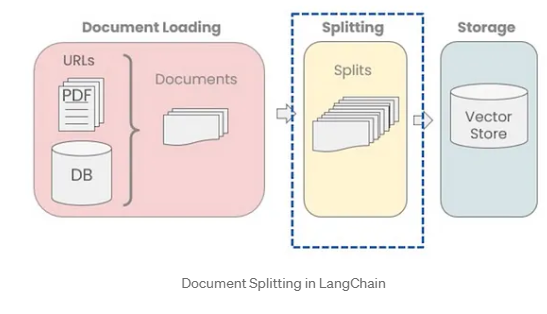

Documents can be very long hence we need to split up not just the documents but the sentences and chunks to keep their meaning. 

The below aims to split the chunks into semantically relevant chunks.

While splitting, we can use overlapping to maintain notion of consistency.

### Example

In [16]:
from langchain.text_splitter import RecursiveCharacterTextSplitter, CharacterTextSplitter

# with open(directory+document_name+'_raw.txt', mode="r", encoding="utf-8") as f:
#     text = f.read()

text = """When writing documents, writers will use document structure to group content. \n\
This can convey to the reader, which idea's are related. For example, closely related ideas \
are in sentances. Similar ideas are in paragraphs. Paragraphs form a document. \n\n  \
Paragraphs are often delimited with a carriage return or two carriage returns. \n\
Carriage returns are the "backslash n" you see embedded in this string. \
Sentences have a period at the end, but also, have a space.\
and words are separated by space.\n\n\
postscript: haha"""

print(f'Length of text given {len(text)}')

chunk_size = 200 # length of each chunk
chunk_overlap = 50 # 

r_splitter = RecursiveCharacterTextSplitter(
    chunk_size=chunk_size,
    chunk_overlap=chunk_overlap,
    separators = ["\n\n", '\n', ' ', '']
)

print('Recursive splitter')
display(r_splitter.split_text(text))

c_splitter = CharacterTextSplitter(
    chunk_size=chunk_size,
    chunk_overlap=chunk_overlap,
    separator = ' '
)
print('\nCharacter splitter')
display(c_splitter.split_text(text))

print('\nUsing token splitting')
token_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=chunk_size, 
    chunk_overlap=chunk_overlap
)
display(token_splitter.split_text(text))

splitted_example = token_splitter.split_text(text)


Length of text given 516
Recursive splitter


['When writing documents, writers will use document structure to group content.',
 "This can convey to the reader, which idea's are related. For example, closely related ideas are in sentances. Similar ideas are in paragraphs. Paragraphs form a document.",
 'Paragraphs are often delimited with a carriage return or two carriage returns.',
 'Carriage returns are the "backslash n" you see embedded in this string. Sentences have a period at the end, but also, have a space.and words are separated by space.',
 'postscript: haha']


Character splitter


["When writing documents, writers will use document structure to group content. \nThis can convey to the reader, which idea's are related. For example, closely related ideas are in sentances. Similar",
 'closely related ideas are in sentances. Similar ideas are in paragraphs. Paragraphs form a document. \n\n Paragraphs are often delimited with a carriage return or two carriage returns. \nCarriage returns',
 'return or two carriage returns. \nCarriage returns are the "backslash n" you see embedded in this string. Sentences have a period at the end, but also, have a space.and words are separated by',
 'but also, have a space.and words are separated by space.\n\npostscript: haha']


Using token splitting


['When writing documents, writers will use document structure to group content. \nThis can convey to the reader, which idea\'s are related. For example, closely related ideas are in sentances. Similar ideas are in paragraphs. Paragraphs form a document. \n\n  Paragraphs are often delimited with a carriage return or two carriage returns. \nCarriage returns are the "backslash n" you see embedded in this string. Sentences have a period at the end, but also, have a space.and words are separated by space.\n\npostscript: haha']

# Vector Store and embedding

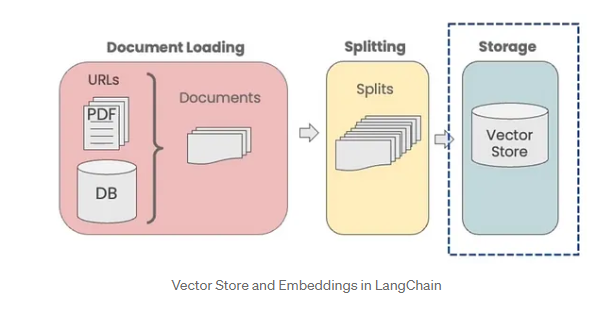

We can customly embed one item to look at the output:

In [19]:
from langchain_openai import OpenAIEmbeddings

# create the open-source embedding function
embedding_function = OpenAIEmbeddings(deployment="SL-document_embedder",
                                      model='text-embedding-ada-002') 

embedding_function.embed_query(splitted_example[0])

[0.00903003163311598,
 0.028933643210075546,
 0.005507179795133747,
 -0.00989482328454938,
 0.008795397957753593,
 -0.00035341647292873134,
 -0.004196584998702097,
 -0.01200652356884325,
 -0.011966300679676056,
 -0.009009920654193653,
 0.004293789926138424,
 0.04574679784344704,
 -0.028290076983400445,
 0.022189610737203762,
 0.011248992334307342,
 0.027780587674831016,
 0.024509129126974376,
 -0.0029061014140234097,
 0.010303755835862094,
 -0.014332745618254641,
 -0.0029966029146495958,
 -0.012154006874907934,
 -0.02525995577054697,
 -0.014185261380867417,
 -0.0037306701762896146,
 0.014238891589316162,
 0.018153916363847902,
 -0.01661204111885806,
 0.014319337367650549,
 0.0016801422996169499,
 0.0006175884978292393,
 -0.006301581157693921,
 -0.022618654267438806,
 -0.01629025800552051,
 -0.003410563210692892,
 0.004783168255785526,
 -0.023342666272448295,
 -0.018529330616956736,
 -0.00553399489935812,
 -0.027485619200056568,
 0.013186393742650885,
 0.008614395422162491,
 0.004082619

In [8]:
from langchain_community.vectorstores import Chroma, FAISS
from langchain_openai import OpenAIEmbeddings


# create the open-source embedding function
embedding_function = OpenAIEmbeddings(deployment="SL-document_embedder",
                                      model='text-embedding-ada-002',
                                      show_progress_bar=True) 

# load it into Chroma
print('Initializing vector_db')
persist_directory = 'ignore/chroma/'
vector_db = Chroma.from_documents(documents = document_chunks_all, 
                                embedding = embedding_function,
                                persist_directory = persist_directory)
print('Complete')


Total length of documents after split : 377
INTRODUCTION A couple of years ago I wrote an article for Fortune  advising people not to go to business school. I argued that it was a waste of time, that for the past hundred years, business schools basically taught one idea: The fundamental goal of every business is to create a hit product, and then sell as many units of that product as possible, thereby diluting fixed costs in order to compete on margins. I said that this model was over, that the situation has changed. Instead, I argued, the goal of business should be to start with the wants and needs of a particular customer base, then create a service that delivers ongoing value to those customers. The idea was to turn customers into subscribers in order to develop recurring revenue. I called the context for this change the Subscription Economy. Oh man, did I get a lot of crap for that article. There were comments like: Do you really think we don’t get it, Tien? That we don’t understand

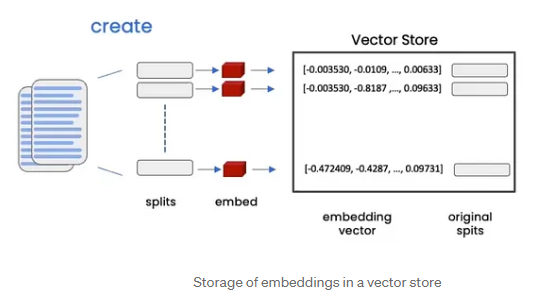

In [9]:
from pprint import pprint

# query it
query = "Resilient and high growth company with positive free cash flow"
docs = vector_db.similarity_search(query)
print(f'Number of matches: {len(docs)}')
print('Top query')
pprint(docs[0].page_content)

100%|██████████| 1/1 [00:00<00:00,  2.98it/s]

Number of matches: 4
Top query
('shares of crowd strike up a few percent  in early morning trading on '
 "Wednesday in  response to the company's upbeat  quarterly results what "
 "happened this  quarter with crowd strike here's  everything you need to know "
 'in about 10  minutes my name is Brian fry as of the  Tim is recording I do '
 'own shares of  crowd strike a $51 billion company  Revenue this quarter was '
 "786 million of  35% easily exceeding wall Street's  estimate and "
 "Management's own guidance  earnings per share similar story more  than "
 'doubled from a year ago period on  an adjusted basis also beating estimates  '
 "and Management's guidance annualized  recurring Revenue eclipsed $3 billion  "
 'this quarter and grew 35% nice strong  growth there one thing that irked me  '
 "probably the only flaw that I saw in  this company's quarterly report is "
 'that  they are no longer reporting on this  chart the dollar-based net '
 'revenue  retention rate this is a chart 

In [10]:
vector_db.delete_collection()